# Introduction
This project analyzes the quality of three types of covariance estimates. In particular, we will compare estimation of the population covariance matrix using a covariance matrix calculated with a Kalman filter, a shrunken sample covariance matrix, and a sample covariance matrix. Our calculations assume that the population means are all zero. This assumption is slightly suspect at the monthly frequency, but it makes it much easier to find reasonable covariance error estimates. 

The data were obtained from the Ken French Data Library. We used equally weighted monthly industry returns. Within this exercise, we will use data from January 1985 to November 2020, inclusive.

Suppose the column vector 
$$
x_t = \left[\begin{array}{c} r_{1, t}\\ r_{2, t} \\ r_{3, t} \\ \vdots \\ r_{n, t}\end{array}\right]
$$
is the vector of returns at time $t$, then we call $x_t x_t'$ the time $t$ covariance actualization. We will use the covariance actualization at time $t$ to estimate the error of covariance matrix estimates using data from time $t - k$ to time $t - 1$. We refer to the value $k$ as the window in our calculations.

To calculate the Kalman covariance estimation $S_\text{kal}$, we can run a Kalman filter on the finite sequence of covariance actualizations
$$
x_{t-k} x_{t-k}',\; x_{t - k + 1}x_{t - k + 1}',\; \ldots,\; \text{and}\; x_{t - 1}x_{t - 1}'.
$$

The calculation of the sample covariance is simply matrix multiplication using a matrix of returns. Specifically, the $k\times n$ matrix
$$
X = \left[\begin{array}{c} x_{t-1}'\\ x_{t - 2}' \\ x_{t-3}' \\ \vdots \\ x_{t - k}'\end{array}\right]\quad\text{implies}\quad S_\text{sam} = \frac{1}{k - 1} X'X, 
$$
where $S_\text{sam}$ denotes the $n\times n$ sample covariance matrix using data from $t - k$ to $t - 1$, inclusive. 

By adding some assumption about the variance of the covariance matrix estimate $S_\text{sam}$, we can find an optimal parameter $\beta \in [0, 1]$ such that
$$
S_{\text{shrk}} = \beta S_{\text{sam}} + (1 - \beta) \frac{\text{tr}(S_\text{sam})}{n} I_n
$$
is a better estimate of covariance actualizations. We call 
$$
\frac{\text{tr}(S_\text{sam})}{n} I_n
$$ 
the target in our calculations. Essentially, the (shrinkage) target would be the best estimate of the covariance matrix if two 
assumptions held:
* the variance of each firms' returns were identical and therefore best estimated by $\text{tr}(S_\text{sam})/n$, and
* and the covariance between any two firms' returns were 0.

These assumptions do not hold, but it is likely at least part of the smallest and largest variance estimates occured by coincidence and some of the sample covariance between firms' returns is spurious. Therefore, some shrinkage of $S_\text{sam}$ to the target is justified.


# Packages and Setup

In [56]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')

In [57]:
# Load equally weighted industry return data
industry = pd.read_csv('10_Industry_Portfolios.csv')

# Convert date column into date-time object
industry['Date'] = pd.to_datetime(industry['Date'], format = '%Y%m') + MonthEnd(0)

# Only consider observations after 1984
industry = industry.loc[industry['Date'].dt.year > 1984, :]

# Reset index
industry.reset_index(inplace = True, drop = True)

# Convert returns to a decimal 
industry.iloc[:, 1:] = industry.iloc[:, 1:].div(100)

industry.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,1985-01-31,0.0902,0.1383,0.1249,0.0397,0.1803,0.1511,0.1204,0.1750,0.0437,0.1200
1,1985-02-28,0.0404,0.0239,0.0347,0.0685,0.0588,0.0774,0.0505,0.0771,0.0127,0.0444
2,1985-03-31,0.0002,-0.0341,-0.0256,-0.0024,-0.0453,0.0489,-0.0110,-0.0222,0.0549,0.0068
3,1985-04-30,-0.0146,-0.0263,-0.0211,-0.0173,-0.0444,-0.0135,-0.0127,-0.0001,0.0231,0.0032
4,1985-05-31,0.0409,-0.0007,0.0249,-0.0274,0.0071,0.0410,0.0331,0.0326,0.0528,0.0313


In [58]:
# Define function to get the Kalman filter covariance matrix S_kal
def kal_cov(X):
    
    # Save number of rows and columns for later use
    rows = X.shape[0]
    cols = X.shape[1]
    
    # Create numpy array to save covariance actualizations
    cov_arr = np.reshape(np.zeros(rows * cols**2), newshape = (rows, cols**2))
    
    # Loop over rows, calculate covariance actualizations, and save result
    for i in range(rows):
        
        x = np.reshape(X[i, :], newshape = (cols, 1))
        
        cov = np.reshape(x @ x.T, newshape = (cols**2, ))
        
        cov_arr[i, :] = cov        
    
    # Save identity matrix and sample covariance matrix for later use
    I = np.eye(cols**2) 
    S = np.reshape(X.T @ X/(rows - 1), newshape = (cols**2, ))
    
    # Initialize Kalman filter
    kf = KalmanFilter(initial_state_mean = S,
                        initial_state_covariance = I,
                        transition_matrices = I,
                        transition_covariance = I,
                        observation_matrices = I,
                        observation_covariance = I)
    
    # Calculate MLE parameter estimates
    kf = kf.em(cov_arr, n_iter = 5)
    
    # Save covariance estimates
    S, _ = kf.smooth(cov_arr)
    
    # Get last covariance estimate
    S = S[-1]
    
    # Reshape estimate
    S = np.reshape(S, newshape = (cols, cols))
    
    return S

# Define function to get the shrunken covariance matrix S_shrk
def shrk_cov(X):
    
    # Save rows and columns for later use
    rows = X.shape[0]
    cols = X.shape[1]
    
    # Record sample covariance matrix
    S = (X.T @ X)/(rows - 1)
        
    # Define target matrix
    target = np.mean(np.diag(S)) * np.eye(cols)
        
    # Define function to help compute omega2
    def calc_error(row):
        
        x = np.reshape(X[row, :], newshape = (cols, 1))
        
        return np.sum((S - x @ x.T)**2)
    
    # Vectorize function
    calc_error = np.vectorize(calc_error)
  
    # Compute non-idiosyncratic variance of variance
    omega2 = np.mean(calc_error(range(rows)))/(rows - 1)
  
    # Calculate total variation of variance
    total_var = np.sum((S - target)**2)
  
    # Calculate idiosyncratic variance of variance
    delta2 = total_var - omega2
  
    # Compute shrinkage parameter
    beta = np.max([delta2/total_var, 0])
  
    # Shrink covariance estimate
    S = beta * S + (1 - beta) * target
    
    return S
  

In [59]:
def get_win_error(window, string):
    
    # Create function to calculate errors
    calc_error = lambda S, x: np.sum((S - x @ x.T)**2)
    
    # Create function to calculate error given row, window, and covariance estimate
    def get_idx_error(row, window, string):
        
        # Values used for covariance estimate
        X = industry.iloc[(row - window):row, 1:].values
        
        # Last observation; used to check accuracy of covariance estimate
        x = np.reshape(industry.iloc[row, 1:].values, newshape = (10, 1))
    
        if string == 'kal':
            
            S = kal_cov(X)
        
        elif string == 'shrk':
            
            S = shrk_cov(X)
            
        elif string == 'sam':
            
            S = (X.T @ X)/(X.shape[0] - 1)
            
        else:
            
            S = np.nan
        
        return calc_error(S, x)
    
    # Vectorize function
    get_idx_error = np.vectorize(get_idx_error)

    # Define array onto which vectorized function is applied
    index = range(window, len(industry))
    
    # Calculate mean of result
    return get_idx_error(index, window, string).mean()

# Vectorize get_win_error
get_win_error = np.vectorize(get_win_error)


# Results
For this data set, the Kalman covariance matrix estimate does poorly despite being far more computationally intensive than the other methods considered. The shrunken covariance matrix does best, but the improvement over the sample covariance matrix is negligible for larger windows. It appears that a window size of about 35 provides the best covariance estimate, but more work ought to be done to verify this.

In [60]:
windows = range(5, 65, 10)

win_errors = pd.DataFrame(columns = ['kal_error', 'shrk_error', 'sam_error'], index = windows)

win_errors['kal_error'] = get_win_error(windows, 'kal')
win_errors['shrk_error'] = get_win_error(windows, 'shrk')
win_errors['sam_error'] = get_win_error(windows, 'sam') 
    
win_errors   

,kal_error,shrk_error,sam_error
5,0.012115,0.010763,0.012116
15,0.012254,0.009758,0.009893
25,0.012459,0.010078,0.010126
35,0.010690,0.008997,0.009000
45,0.010859,0.009314,0.009306
55,0.011135,0.009590,0.009580


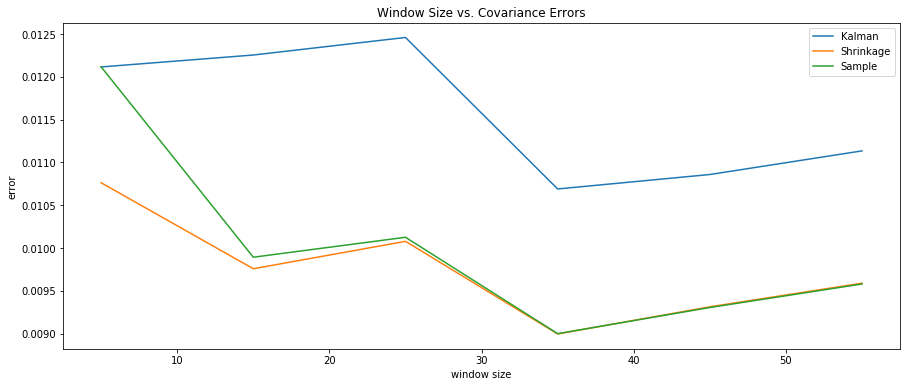

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (15,6))

ax.plot(win_errors.index, win_errors['kal_error'], label = 'Kalman')
ax.plot(win_errors.index, win_errors['shrk_error'], label = 'Shrinkage')
ax.plot(win_errors.index, win_errors['sam_error'], label = 'Sample')
ax.set_xlabel('window size') 
ax.set_ylabel('error') 
ax.set_title('Window Size vs. Covariance Errors')
ax.legend()

plt.show()